# Analyse IMGEP Evaluation

In [1]:
from autodiscjax import DictTree
from autodiscjax.utils.timeseries import is_stable
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from sklearn.cluster import MeanShift, estimate_bandwidth

## Load experiment+evaluation history

In [2]:
experiment_history_filepath = "experiment_data/experiment_history.pickle"
experiment_history = DictTree.load(experiment_history_filepath)

evaluation_history_filepath = "evaluation_data/evaluation_history.pickle"
evaluation_history = DictTree.load(evaluation_history_filepath)

## Goals of the system

In [3]:
observed_node_ids = jnp.array([0,1])
ymax = jnp.array([7866.401, 4771.8975, 1377.4222, 1086.2181])
ymin = jnp.array([91.93025, 100.43926, 15.655377, 53.970665])

### Filter out non-convergent trajectories

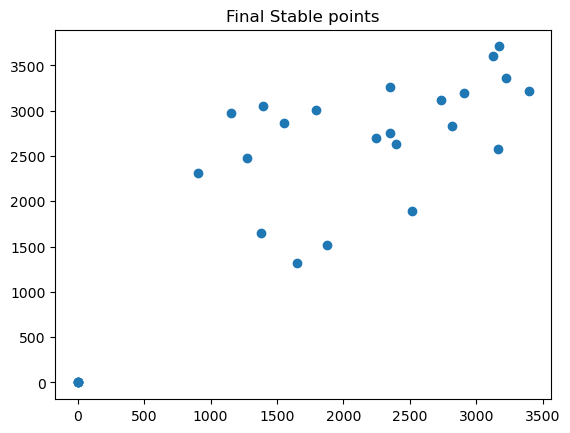

In [4]:
experiment_trajectories = experiment_history.system_output_library.ys[:, observed_node_ids, :]
is_stable_bool, mean_vals, std_vals = is_stable(experiment_trajectories, time_window=jnp.r_[-100:0], std_epsilon=1e-3*(ymax-ymin)[jnp.newaxis, observed_node_ids])
is_stable_bool = is_stable_bool.all(-1)
has_converged_ids = jnp.where(is_stable_bool)[0]

# goals = bins where they are final (stable) points
plt.figure()
plt.scatter(
    experiment_history.system_output_library.ys[has_converged_ids, observed_node_ids[0], -1],
    experiment_history.system_output_library.ys[has_converged_ids, observed_node_ids[1], -1],
)
plt.title("Final Stable points")
plt.show()

### Bin-based definition

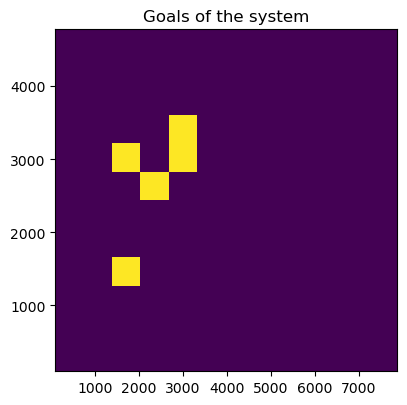

In [5]:
Hf, xedges, yedges = jnp.histogram2d(
    x=experiment_history.system_output_library.ys[has_converged_ids, observed_node_ids[0], -1],
    y=experiment_history.system_output_library.ys[has_converged_ids, observed_node_ids[1], -1],
    bins=12,
    range=jnp.stack(
        [ymin[observed_node_ids], ymax[observed_node_ids]]
    ).transpose(),
)
Hf = Hf.transpose() > 1
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(131, title="Goals of the system")
plt.imshow(
    Hf,
    interpolation="nearest",
    origin="lower",
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    aspect=(ymax[observed_node_ids[0]] - ymin[observed_node_ids[0]])
    / (ymax[observed_node_ids[1]] - ymin[observed_node_ids[1]]),
)
# plt.colorbar()
plt.show()

### Clustering-based definition

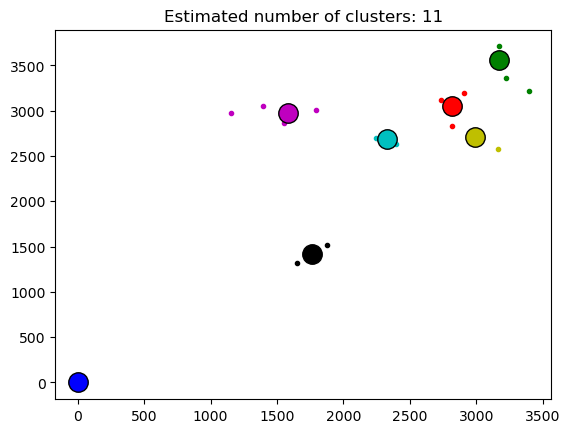

In [56]:
X = experiment_history.system_output_library.ys[:, observed_node_ids, -1][has_converged_ids]

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.15, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = jnp.unique(labels)
n_clusters_ = len(labels_unique)

plt.figure(1)
plt.clf()

colors = "bgrcmyk"
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + ".")
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=14,
    )
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

## (Goal-directed) Robustness of the system

0.0036605625064112246
0.027377770747989416
0.006627571419812739
0.009399508708156645
0.021181609481573105
0.01981397159397602
0.003252666792832315


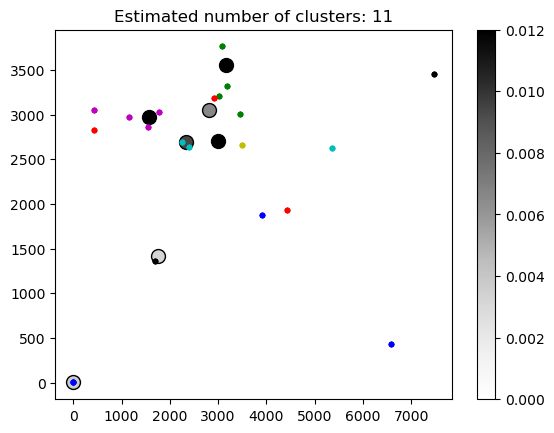

In [57]:
plt.figure(1)
plt.clf()

#TODO: normalize distance

colors = "bgrcmyk"
cm = plt.cm.get_cmap('Greys')

for cluster_idx, col in zip(range(n_clusters_), colors):
    
    cluster_members = labels == cluster_idx
    cluster_center = cluster_centers[cluster_idx]
    cluster_X = evaluation_history.system_output_library.ys[has_converged_ids, :, :, -1][cluster_members][...,observed_node_ids].reshape(-1, len(observed_node_ids))
    
    cluster_sensitivity = jnp.sqrt(((cluster_center[jnp.newaxis] - cluster_X)** 2).sum(-1))
    cluster_robustness = 10*jnp.reciprocal(cluster_sensitivity.mean()).item()
    print(cluster_robustness)

    plt.plot(cluster_X[:, 0], cluster_X[:, 1], col + ".")
    plt.scatter(
        [cluster_center[0]],
        [cluster_center[1]],
        marker="o",
        c=cluster_robustness,
        edgecolor="k",
        s=100,
        cmap=cm,
        vmin=0,
        vmax=0.012
    )

plt.colorbar()
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()